# Collaborative Filtering Recommender System - Expedia Hotel dataset

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import warnings


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score


In [151]:
hotel_train_set = pd.read_csv('train.csv', sep=',', nrows=100000)
hotel_train_set.shape

(100000, 24)

### Read train and test data

In [82]:
hotel_train_set.head(n=2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1


In [83]:
hotel_train_set.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

In [191]:
len(hotel_train_set['srch_destination_id'].unique()),len(hotel_train_set['hotel_cluster'].unique())

(5296, 100)

In [192]:
#df = hotel_train_set[['user_id','srch_destination_id','is_booking']]
df = hotel_train_set[['user_id','hotel_cluster','is_booking']]

In [193]:
df.head()

,user_id,hotel_cluster,is_booking
0,12,1,0
1,12,1,1
2,12,1,0
3,93,80,0
4,93,21,0


In [194]:
df.columns =['user_id', 'item_id', 'rating']

In [195]:
df.head()

,user_id,item_id,rating
0,12,1,0
1,12,1,1
2,12,1,0
3,93,80,0
4,93,21,0


In [196]:
train, test = train_test_split(df, test_size=0.3)

train.shape, test.shape

((70000, 3), (30000, 3))

# Find Similar Hotel clusters

In [198]:
ratings = pd.DataFrame(df.groupby('item_id')['rating'].mean())
ratings.head()

,rating
item_id,
0,0.054990
1,0.089302
2,0.107579
3,0.072488
4,0.101871


In [199]:
ratings['number_ratings'] = pd.DataFrame(df.groupby('item_id')['rating'].count())
ratings.head()

,rating,number_ratings
item_id,,
0,0.054990,982
1,0.089302,1075
2,0.107579,1227
3,0.072488,607
4,0.101871,962


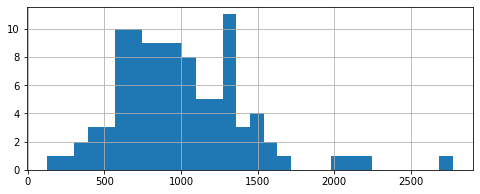

In [200]:
#We can see from the below figure that most of the movies have few number of ratings.
plt.figure(figsize=(8,3))
ratings['number_ratings'].hist(bins=30)

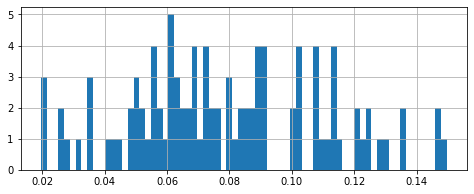

In [201]:
# This histogram shows the distribution of rating 
plt.figure(figsize=(8,3))
ratings['rating'].hist(bins=70)

In [202]:
hotel_matrix = df.pivot_table(index='user_id',columns='item_id',values='rating')

In [203]:
hotel_matrix.head()

item_id,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
12,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
756,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
def find_similar_clusters(cluster_number):
    #Select user ratings for twohotel_matrixmovies 
    item_user_ratings = movie_matrix[cluster_number]

    # Find correlations between series with corrwith (instead of corr)
    similar_to_hotel = hotel_matrix.corrwith(item_user_ratings)

    # Removing NaN values and using a DataFrame instead of a series 
    corr_hotel = pd.DataFrame(similar_to_hotel,columns=['Correlation'])
    corr_hotel.dropna(inplace=True)

    corr_hotel = corr_hotel.join(ratings['number_ratings'])

    result = corr_hotel[corr_hotel['number_ratings']>0].sort_values('Correlation',ascending=False).head()
    return result

In [206]:
warnings.filterwarnings("ignore")
find_similar_clusters(11)

,Correlation,number_ratings
item_id,,
11,1.000000,919
57,0.423323,803
24,0.389115,461
40,0.388881,1060
12,0.373163,700


# Recommendation Engine - collaborative filtering model from scratch

## Memory-Based CF by computing cosine similarity

In [207]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
n_users,n_items

(3478, 100)

In [211]:
x=[]
for line in df.itertuples():
    x.append(line[1])
len(np.unique(x))

3478

In [216]:
df.head()

,user_id,item_id,rating
0,12,1,0
1,12,1,1
2,12,1,0
3,93,80,0
4,93,21,0


In [215]:
data_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

IndexError: index 3924 is out of bounds for axis 0 with size 3478

In [208]:
list(df.itertuples())

[Pandas(Index=0, user_id=12, item_id=1, rating=0),
 Pandas(Index=1, user_id=12, item_id=1, rating=1),
 Pandas(Index=2, user_id=12, item_id=1, rating=0),
 Pandas(Index=3, user_id=93, item_id=80, rating=0),
 Pandas(Index=4, user_id=93, item_id=21, rating=0),
 Pandas(Index=5, user_id=93, item_id=92, rating=0),
 Pandas(Index=6, user_id=501, item_id=41, rating=0),
 Pandas(Index=7, user_id=501, item_id=41, rating=0),
 Pandas(Index=8, user_id=501, item_id=69, rating=0),
 Pandas(Index=9, user_id=501, item_id=70, rating=0),
 Pandas(Index=10, user_id=501, item_id=98, rating=0),
 Pandas(Index=11, user_id=501, item_id=10, rating=0),
 Pandas(Index=12, user_id=756, item_id=18, rating=0),
 Pandas(Index=13, user_id=756, item_id=28, rating=0),
 Pandas(Index=14, user_id=756, item_id=25, rating=0),
 Pandas(Index=15, user_id=756, item_id=25, rating=0),
 Pandas(Index=16, user_id=756, item_id=25, rating=0),
 Pandas(Index=17, user_id=756, item_id=25, rating=0),
 Pandas(Index=18, user_id=756, item_id=25, rati

In [172]:
# create a user-item matrix which can be used to calculate the similarity between users and items

data_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

    
# because of splitting the data into test and train we need to create two [943 x 1682] matrices

train_data_matrix = np.zeros((n_users, n_items))
# unpack the Pandas object
for line in train.itertuples():
    # adjust to count rows and cols from 0 and fill in the matrix
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

IndexError: index 3924 is out of bounds for axis 0 with size 3478

In [93]:
train_data_matrix.shape, test_data_matrix.shape

NameError: name 'train_data_matrix' is not defined

In [44]:
# calculating the similarity by using the pairwise_distance from sklearn to calculate the cosine similarity
from sklearn.metrics.pairwise import pairwise_distances 

# user-user similarity
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')

# item-item similarity
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

user_similarity.shape , item_similarity.shape

((943, 943), (1682, 1682))

we can make a prediction by applying the following formula for user-based CF.


1) We can look at the similarity between users k and a as weights

2)  weights are multiplied by the ratings of a similar user a (corrected for the average rating of that user)

3) We need to normalize it so that the ratings stay between 1 and 5

4) As a final step, sum the average ratings for the user that you are trying to predict.

$$\hat{x}_{k,m}= \bar{x}_{k} + \frac{\sum_{u_{a}}sim_{u}(u_{k},u_{a})(x_{a,m}-\bar{x}_{u_{a}})}
{\sum_{u_{a}\left | sim_{u}(u_{k},u_{a}) \right |}}
$$

Also, we can make a prediction by applying the following formula for item-based CF.

 $$\hat{x}_{k,m}=  \frac{\sum_{i_{b}}sim_{i}(i_{m},i_{b})(x_{k,b})}
{\sum_{i_{b}\left | sim_{i}(i_{m},i_{b}) \right |}}
$$

In [50]:
#make predictions based on these similarities

def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [51]:
user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

user_prediction.shape,item_prediction.shape

((943, 1682), (943, 1682))

## Model-Based CF by using singular value decomposition (SVD)

$$X = USV^{T}$$



In [89]:
sparsity = round(1.0-len(df)/float(n_users*n_items), 3)
print('The sparsity level of MovieLens100K is ' + str(sparsity*100) + '%')


import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k=20)
s_diag_matrix=np.diag(s)

#prediction
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

The sparsity level of MovieLens100K is 93.7%


## Evaluation with RMSE and MAE

In [90]:
def rmse(prediction, y):
    prediction = prediction[y.nonzero()].flatten()
    y = y[y.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, y))

def mae(prediction, y):
    prediction = prediction[y.nonzero()].flatten()
    y = y[y.nonzero()].flatten()
    return sqrt(mean_absolute_error(prediction, y))

print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))
print('Model-Based CF RMSE: ' + str(rmse(X_pred, test_data_matrix)))
print("\n")
print('User-based CF MAE: ' + str(mae(user_prediction, test_data_matrix)))
print('Item-based CF MAE: ' + str(mae(item_prediction, test_data_matrix)))
print('Model-Based CF MAE: ' + str(mae(X_pred, test_data_matrix)))

User-based CF RMSE: 3.1801799301154703
Item-based CF RMSE: 3.6039427909848873
Model-Based CF RMSE: 2.8258075694458307


User-based CF MAE: 1.7252144402114702
Item-based CF MAE: 1.849034489369964
Model-Based CF MAE: 1.5957847598859092


## Evaluation with Precision and recall
Precision and recall are binary metrics used to evaluate models with binary output. 

We need a way to translate the ratings from 1 to 5 into a binary problem.

To do the translation we will assume that any true rating above 3.5 corresponds to a relevant item and any true rating below 3.5 is irrelevant. 

We are intrested in recommending top-N items to the user. So it makes more sense to compute precision and recall metrics in the first N items instead of all the items.

Thus the notion of precision and recall at k where k is a user definable integer that is set by the user to match the top-N recommendations objective.

In [ ]:
# threshold = 3.5


# Fast AI

In [131]:
df.head()

,user_id,item_id,rating
0,12,8250,0
1,12,8250,1
2,12,8250,0
3,93,14984,0
4,93,14984,0


In [173]:
# import collaborative filtering package
from fastai.collab import *

In [174]:
# Turn the title columns in category codes(to replace them with their codes for an Embedding layer)
# size of our validation set = 0.1
# we can add rating_name and user_name too.

data = CollabDataBunch.from_df(df, seed=42, valid_pct=0.1, 
                                      user_name='user_id', item_name='item_id', rating_name='rating')

In [175]:
#show a random batch of our data
data.show_batch()

user_id,item_id,target
307133,57,0.0
273160,47,1.0
338070,43,0.0
225058,6,0.0
163725,28,0.0


In [176]:
#getting the max and min values of our ratings
df.rating.min(), df.rating.max()

(0, 1)

## EmbeddingDotBias

In [177]:
# creat Learner object (our model)
# n_factors represents the size of the embedding vectors

#EmbeddingDotBias
learn = collab_learner(data, n_factors=40, y_range=(0,1), wd=1e-1)


#EmbeddingNN Model
#learn = collab_learner(data, n_factors=40, y_range=(1,5), use_nn=True, layers=[256, 128])

In [178]:
print(learn.model)

EmbeddingDotBias(
  (u_weight): Embedding(3476, 40)
  (i_weight): Embedding(101, 40)
  (u_bias): Embedding(3476, 1)
  (i_bias): Embedding(101, 1)
)


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


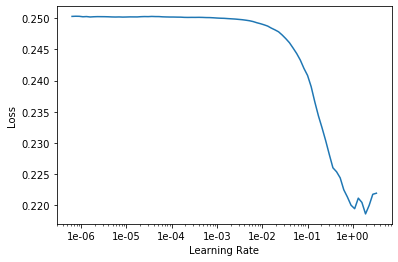

In [179]:
# find the perfect learning rates we can use the lr_find 
learn.lr_find()
# plot learning rate graph
learn.recorder.plot()

In [180]:
# Train our model using the fit_one_cycle method
learn.fit_one_cycle(4, 1e-02)

epoch,train_loss,valid_loss,time
0,0.077787,0.077027,00:11
1,0.078648,0.074983,00:11
2,0.073990,0.074291,00:11
3,0.066751,0.074493,00:11


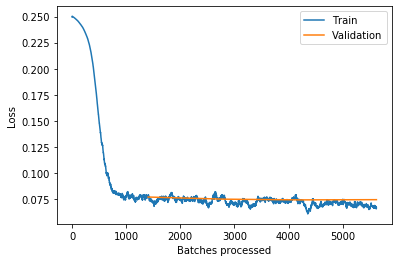

In [181]:
learn.recorder.plot_losses()

In [217]:
learn.save('hotel-dot')

In [218]:
df.head()

,user_id,item_id,rating
0,12,1,0
1,12,1,1
2,12,1,0
3,93,80,0
4,93,21,0


In [220]:
learn = learn.load('hotel-dot')

In [221]:
preds, y = learn.get_preds(ds_type=DatasetType.Valid)

In [222]:
preds

tensor([1.7267e-01, 1.6089e-05, 1.5639e-02,  ..., 8.7228e-02, 2.6394e-02,
        7.3647e-03])

In [223]:
y, y.shape

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), torch.Size([10000]))

In [224]:
print('Fastai CF RMSE: ' + str(rmse(preds, y)))
print('Fastai CF MAE: ' + str(mae(preds, y)))

Fastai CF RMSE: tensor(0.2729)
Fastai CF MAE: tensor(0.1435)


### Recommend hotel cluster for a user

In [189]:
rows = []
movies = list(df.drop_duplicates(subset='item_id', keep='first').item_id)
names = list(df.drop_duplicates(subset='item_id', keep='first').item_id)

for i in range(len(movies)):
    rows.append( dict({'name': names[i], 'item_id' : movies[i], 'user_id' : 9}))
test_data = pd.DataFrame(rows)

In [225]:
for idx, (score, name) in enumerate(sorted(zip(preds, names), reverse=True)):
    if idx >= 10:
        break
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  0.4  for hotel cluster:  33
Score:  0.35  for hotel cluster:  81
Score:  0.3  for hotel cluster:  45
Score:  0.29  for hotel cluster:  15
Score:  0.27  for hotel cluster:  32
Score:  0.26  for hotel cluster:  25
Score:  0.25  for hotel cluster:  28
Score:  0.23  for hotel cluster:  88
Score:  0.22  for hotel cluster:  23
Score:  0.22  for hotel cluster:  96


# Resources

https://blog.cambridgespark.com/nowadays-recommender-systems-are-used-to-personalize-your-experience-on-the-web-telling-you-what-120f39b89c3c

https://course.fast.ai/videos/?lesson=4

https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00

https://medium.com/quantyca/deep-learning-for-collaborative-filtering-using-fastai-b28e197ccd59